# Snakes

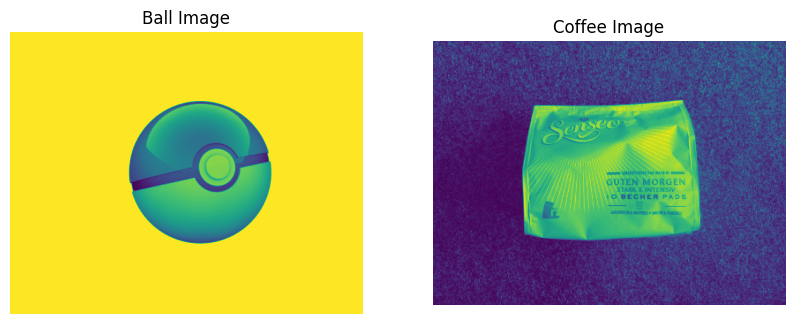

In [36]:
import cv2
import matplotlib.pyplot as plt

ball = cv2.imread("./ball.png")
coffee = cv2.imread("./coffee.png")

ballGray = cv2.cvtColor(ball, cv2.COLOR_BGR2GRAY) #converting bgr to rgb
coffeeGray = cv2.cvtColor(coffee, cv2.COLOR_BGR2GRAY)

#display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ballGray)
plt.title("Ball Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(coffeeGray)
plt.title("Coffee Image")
plt.axis("off")

plt.show()

# Drawing the initial circle

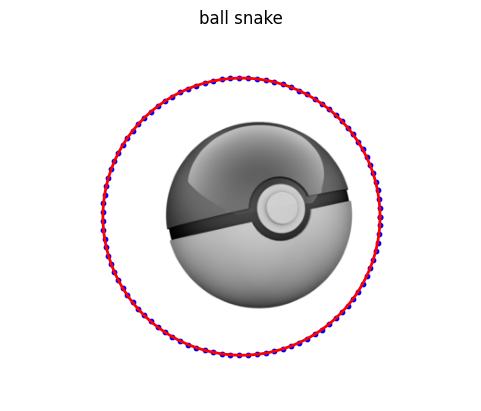

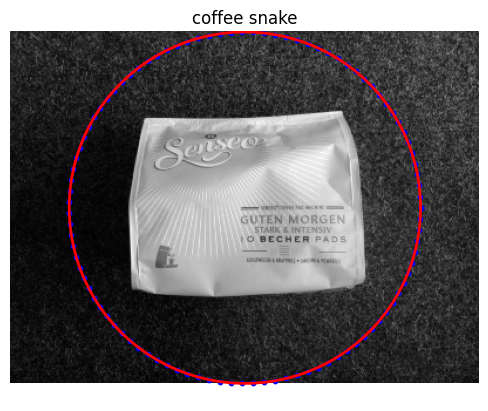

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_snake( center, radius, num_points):
   
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    snake = np.array([x, y]).T # x and y coords in an array

    return snake

def visualize_snake(image, snake, title="Initialized Snake"):

    plt.imshow(image, cmap='gray')
    plt.plot(snake[:, 0], snake[:, 1], '-r', linewidth=2)
    plt.scatter(snake[:, 0], snake[:, 1], c='blue', s=10)  # Points of the snake
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Example parameters
    img = np.ones((200, 200)) * 255  # Dummy image
    center = (250, 200)  # Center of the circle
    radius = 150  # Ra
    snake = initialize_snake(center, radius , 100)
    snakeCoffee = initialize_snake((200,150), 150 , 100)
    visualize_snake(ballGray , snake , "ball snake")
    visualize_snake(coffeeGray, snakeCoffee, "coffee snake")





# Compute Gradient Image

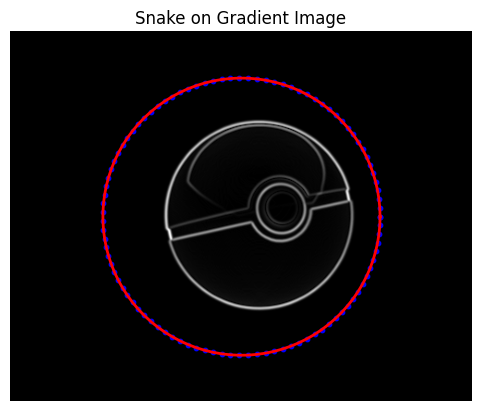

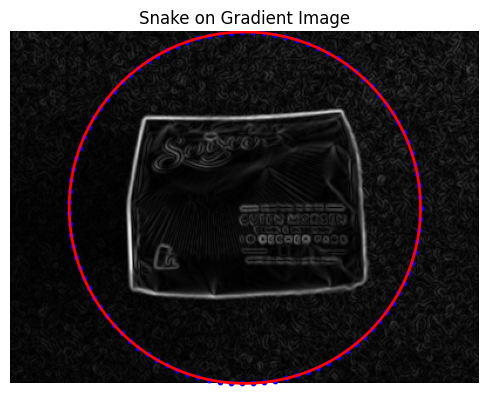

In [75]:
def gradient(image):
    k_y = np.array([[ 0,-1,0 ], [ 0,0,0], [0,1,0]])
    k_x = np.transpose(k_y)
    
    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)
    
    return gradient_x, gradient_y

ballGrayBlurred = cv2.GaussianBlur(ballGray,(5,5),0) 
gradient_x, gradient_y = gradient(ballGrayBlurred)
norm_image_gradient = np.sqrt(gradient_x**2 + gradient_y**2)

coffeeGrayBlurred = cv2.GaussianBlur(coffeeGray,(5,5),0) 
Cofgradient_x, Cofgradient_y = gradient(coffeeGrayBlurred)
coffeeGradient = np.sqrt(Cofgradient_x**2 + Cofgradient_y**2)


visualize_snake(norm_image_gradient, snake, title="Snake on Gradient Image")
visualize_snake(coffeeGradient, snakeCoffee, title="Snake on Gradient Image")

# External Energy Function

In [ ]:
def calculateExternal(gradientImage):  
  
    x, y = gradientImage.shape # Compute dimensions of the image

    external_energy = -(gradient_x**2 + gradient_y**2)
    E_external = cv2.normalize(external_energy, None, 0, 255, cv2.NORM_MINMAX)
    return E_external


# Internal Energy Function

In [ ]:
import numpy as np

def compute_internal_energy(snake, alpha=0.1, beta=0.1):
    num_points = len(snake)
    
    distances = np.sqrt( #elasticity
        (np.roll(snake[:, 0], -1) - snake[:, 0])**2 +
        (np.roll(snake[:, 1], -1) - snake[:, 1])**2
    )
    avg_distance = np.mean(distances)
    elasticity = alpha * (distances - avg_distance)**2

    
    curvature = beta * ( #curvature
        (np.roll(snake[:, 0], -1) - 2 * snake[:, 0] + np.roll(snake[:, 0], 1))**2 +
        (np.roll(snake[:, 1], -1) - 2 * snake[:, 1] + np.roll(snake[:, 1], 1))**2
    )

    # Total internal energgy
    internal_energy = elasticity + curvature
    
    return internal_energy

E_internal =compute_internal_energy(snake)
E_external = calculateExternal(norm_image_gradient)

E_internal_coffee = compute_internal_energy(snakeCoffee)
E_external_coffee = calculateExternal(coffeeGradient)


# Updating the snake's pos w/ dynamic programming

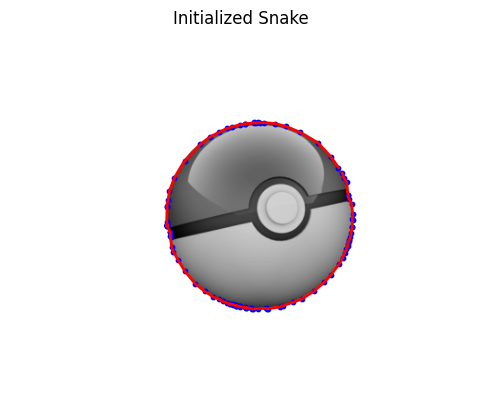

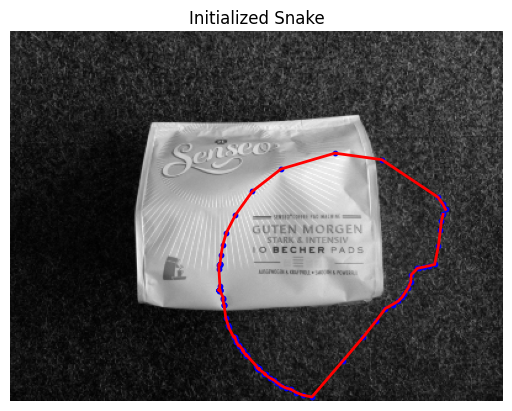

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def updateSnake(snake, energyExternal, alpha=0.01, beta=0.01, num_iterations=1000, neighborhood_size=3):

    numPoints = len(snake)
    halfOfNeighbors = neighborhood_size // 2
    directions = [(dx, dy) for dx in range(-halfOfNeighbors, halfOfNeighbors + 1)
                  for dy in range(-halfOfNeighbors, halfOfNeighbors + 1)]

    for iteration in range(num_iterations):
        newSnake = np.zeros_like(snake)

        for i in range(numPoints):
            currentPoint = snake[i]
            prevPoint = snake[(i - 1) % numPoints]
            nextPoint = snake[(i + 1) % numPoints]

            minEnergy = float('inf')
            bestPoint = currentPoint

            for dx, dy in directions:
                candidatePoint = currentPoint + np.array([dx, dy])
                candidatePoint = np.clip(candidatePoint, 0, np.array(energyExternal.shape) - 1)

                energyExtNew = energyExternal[int(candidatePoint[1]), int(candidatePoint[0])] # calculate external

                elasticity = alpha * np.sum((candidatePoint - prevPoint) ** 2) #calculate internal energy
                curvature = beta * np.sum((prevPoint - 2 * candidatePoint + nextPoint) ** 2)

                total_energy = energyExtNew + elasticity + curvature

                 
                if total_energy < minEnergy: # update the best 
                    minEnergy = total_energy
                    bestPoint = candidatePoint

            
            newSnake[i] = bestPoint #updating the point

        snake = newSnake

    return snake

newSnake = updateSnake(snake, E_external)
visualize_snake(ballGray, newSnake)

newCoffeeSnake = updateSnake(snakeCoffee, E_external_coffee)
visualize_snake(coffeeGray, newCoffeeSnake)
